### Loading the pre trained models

In [35]:
from keras.models import load_model

In [36]:
cnn_model = load_model('models/cnn_w2v.keras')
cnn_model_debiased = load_model('models/cnn_w2v_debiased.keras')

### Loading and preprocessing the EEC data

In [37]:
import nltk
import numpy as np
import pandas as pd

In [38]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness','neutral']

In [39]:
eec_df = pd.read_csv('./data/Equity-Evaluation-Corpus.csv')

In [40]:
eec_df['Emotion'].unique()

array(['anger', 'sadness', 'fear', 'joy', nan], dtype=object)

In [41]:
eec_df.isna().sum()

ID                 0
Sentence           0
Template           0
Person             0
Gender             0
Race            2880
Emotion          240
Emotion word     240
dtype: int64

In [42]:
# Drop rows with null values in the 'Emotion' column
eec_df = eec_df.dropna(subset=['Emotion'])
eec_df.isna().sum()

ID                 0
Sentence           0
Template           0
Person             0
Gender             0
Race            2800
Emotion            0
Emotion word       0
dtype: int64

In [43]:
gender_eec_df = eec_df[eec_df['Race'].isna()][:]
gender_eec_df.head()
class_distribution = gender_eec_df['Emotion'].value_counts()
print("Class Distribution:")
print(class_distribution)

Class Distribution:
Emotion
anger      700
sadness    700
fear       700
joy        700
Name: count, dtype: int64


In [44]:
gender_eec_df.head()

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
400,2018-En-mystery-06888,He feels angry.,<person subject> feels <emotion word>.,he,male,NaN,anger,angry
401,2018-En-mystery-04660,He feels furious.,<person subject> feels <emotion word>.,he,male,NaN,anger,furious
402,2018-En-mystery-13903,He feels irritated.,<person subject> feels <emotion word>.,he,male,NaN,anger,irritated
403,2018-En-mystery-00129,He feels enraged.,<person subject> feels <emotion word>.,he,male,NaN,anger,enraged
404,2018-En-mystery-10867,He feels annoyed.,<person subject> feels <emotion word>.,he,male,NaN,anger,annoyed


In [45]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
}
gender_eec_df['Encoded_Emotion'] = gender_eec_df['Emotion'].map(encoding)
gender_eec_df


,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word,Encoded_Emotion
400,2018-En-mystery-06888,He feels angry.,<person subject> feels <emotion word>.,he,male,NaN,anger,angry,2
401,2018-En-mystery-04660,He feels furious.,<person subject> feels <emotion word>.,he,male,NaN,anger,furious,2
402,2018-En-mystery-13903,He feels irritated.,<person subject> feels <emotion word>.,he,male,NaN,anger,irritated,2
403,2018-En-mystery-00129,He feels enraged.,<person subject> feels <emotion word>.,he,male,NaN,anger,enraged,2
404,2018-En-mystery-10867,He feels annoyed.,<person subject> feels <emotion word>.,he,male,NaN,anger,annoyed,2
...,...,...,...,...,...,...,...,...,...
8635,2018-En-mystery-12020,The conversation with my mom was funny.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,funny,0
8636,2018-En-mystery-14529,The conversation with my mom was hilarious.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,hilarious,0
8637,2018-En-mystery-16746,The conversation with my mom was amazing.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,amazing,0
8638,2018-En-mystery-00046,The conversation with my mom was wonderful.,The conversation with <person object> was <emo...,my mom,female,NaN,joy,wonderful,0


### Preprocessing

In [48]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical



In [49]:
# Create identifier to mach sentence pairs
# The EEC data comes withot this matching
MALE_PERSONS = ('he', 'this man', 'this boy', 'my brother', 'my son', 'my husband',
                'my boyfriend', 'my father', 'my uncle', 'my dad', 'him')

FEMALE_PERSONS = ('she', 'this woman', 'this girl', 'my sister', 'my daughter', 'my wife',
                  'my girlfriend', 'my mother', 'my aunt', 'my mom', 'her')

MALE_IDENTIFIER = dict(zip(MALE_PERSONS, FEMALE_PERSONS))
FEMALE_IDENTIFIER = dict(zip(FEMALE_PERSONS, FEMALE_PERSONS))

PERSON_MATCH_WORDS = {**MALE_IDENTIFIER,
                      **FEMALE_IDENTIFIER}

gender_eec_df['PersonIdentifier'] = gender_eec_df['Person'].map(PERSON_MATCH_WORDS)

gender_eec_df = gender_eec_df.sort_values(['Gender', 'Template', 'Emotion word', 'PersonIdentifier'])

gender_split_index = len(gender_eec_df) // 2

# Create two DataFrames, one for 
female_eec_df = gender_eec_df[:gender_split_index].reset_index(False)
male_eec_df = gender_eec_df[gender_split_index:].reset_index(False)

In [50]:
paired_sentences = pd.merge(male_eec_df, female_eec_df, 
                             on=['Template', 'Emotion', 'PersonIdentifier'], 
                             suffixes=('_male', '_female'))
anger_sentences = paired_sentences[paired_sentences['Emotion'] == 'anger']
sadness_sentences =  paired_sentences[paired_sentences['Emotion'] == 'sadness']

In [73]:
joy_sentences =  paired_sentences[paired_sentences['Emotion'] == 'joy']

### Evaluation of Gender Bias

In [51]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [52]:
from keras.preprocessing.text import tokenizer_from_json
import json

# Load tokenizer from JSON file
with open('embeddings/tokenizer.json') as json_file:
    tokenizer_json = json.load(json_file)
    tokenizer = tokenizer_from_json(tokenizer_json)


In [53]:
index_of_words = tokenizer.word_index


In [54]:
def preprocess_eec_sentences(eec_texts, tokenizer, max_seq_len):
    texts = [' '.join(clean_text(text)) for text in eec_texts]
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_seq_len)
    return padded_sequences

In [57]:
male = paired_sentences['Sentence_male']
female = paired_sentences['Sentence_female']
X_male = preprocess_eec_sentences(male,tokenizer,max_seq_len)
X_female = preprocess_eec_sentences(female,tokenizer,max_seq_len)

In [55]:
male_anger = anger_sentences['Sentence_male']
female_anger = anger_sentences['Sentence_female']
X_male_anger = preprocess_eec_sentences(male_anger,tokenizer,max_seq_len)
X_female_anger = preprocess_eec_sentences(female_anger,tokenizer,max_seq_len)

In [58]:
# Get the predicted probabilities for all class
probabilities_male = cnn_model.predict(X_male)  # This will return probabilities for all classes
probabilities_female = cnn_model.predict(X_female)

219/219 [==============================] - 19s 88ms/step


In [59]:
# Get the predicted probabilities for all class
probabilities_male_anger = cnn_model.predict(X_male_anger)  # This will return probabilities for all classes
probabilities_female_anger = cnn_model.predict(X_female_anger)

55/55 [==============================] - 5s 94ms/step


In [61]:
# Assign the probabilities to the DataFrame
# Each column corresponds to the probability of a specific class
anger_sentences[['Probabilities_class_0', 'Probabilities_class_1', 
                  'Probabilities_class_2', 'Probabilities_class_3','Probabilities_class_4']] = probabilities_male_anger

# Similarly, for the female data
anger_sentences[['Probabilities_class_0_female', 'Probabilities_class_1_female', 
                  'Probabilities_class_2_female', 'Probabilities_class_3_female','Probabilities_class_4']] = probabilities_female_anger

C:\Users\Nivetha\AppData\Local\Temp\ipykernel_26788\330911612.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sentences[['Probabilities_class_0', 'Probabilities_class_1',
C:\Users\Nivetha\AppData\Local\Temp\ipykernel_26788\330911612.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sentences[['Probabilities_class_0', 'Probabilities_class_1',
C:\Users\Nivetha\AppData\Local\Temp\ipykernel_26788\330911612.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [63]:
# Assign the probabilities to the DataFrame
# Each column corresponds to the probability of a specific class
paired_sentences[['Probabilities_class_0', 'Probabilities_class_1', 
                  'Probabilities_class_2', 'Probabilities_class_3','Probabilities_class_4']] = probabilities_male

# Similarly, for the female data
paired_sentences[['Probabilities_class_0_female', 'Probabilities_class_1_female', 
                  'Probabilities_class_2_female', 'Probabilities_class_3_female','Probabilities_class_4']] = probabilities_female

### DEBIASED WORD EMBEDDING

In [81]:
probabilities_male_debiased_anger = cnn_model_debiased.predict(X_male_anger)  # This will return probabilities for all classes
probabilities_female_debiased_anger = cnn_model_debiased.predict(X_female_anger)

55/55 [==============================] - 5s 94ms/step


In [82]:
# Assign the probabilities to the DataFrame
# Each column corresponds to the probability of a specific class
anger_sentences[['class_0_debiased', 'class_1_debiased', 
                  'class_2_debiased', 'class_3_debiased','class_4_debiased']] = probabilities_male_debiased_anger

# Similarly, for the female data
anger_sentences[['class_0_debiased_female', 'class_1_debiased_female', 
                  'class_2_debiased_female', 'class_3_debiased_female','class_4_debiased_female']] = probabilities_female_debiased_anger

C:\Users\Nivetha\AppData\Local\Temp\ipykernel_26788\852521301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sentences[['class_0_debiased', 'class_1_debiased',
C:\Users\Nivetha\AppData\Local\Temp\ipykernel_26788\852521301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anger_sentences[['class_0_debiased', 'class_1_debiased',
C:\Users\Nivetha\AppData\Local\Temp\ipykernel_26788\852521301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

### Statistical Analysis

In [64]:
sampled_data = paired_sentences.sample(n=1000, random_state=42)
sampled_data['Emotion'].unique()

array(['sadness', 'joy', 'anger', 'fear'], dtype=object)

In [84]:
sampled_data_anger = anger_sentences.sample(n=1000, random_state=42)
sampled_data_anger['Emotion'].unique()

array(['anger'], dtype=object)

In [88]:
sampled_data_anger

,index_male,ID_male,Sentence_male,Template,Person_male,Gender_male,Race_male,Emotion,Emotion word_male,Encoded_Emotion_male,...,class_0_debiased,class_1_debiased,class_2_debiased,class_3_debiased,class_4_debiased,class_0_debiased_female,class_1_debiased_female,class_2_debiased_female,class_3_debiased_female,class_4_debiased_female
4246,2822,2018-En-mystery-05600,I made this man feel irritated.,I made <person object> feel <emotion word>.,this man,male,NaN,anger,irritated,2,...,0.001577,0.032246,0.907077,0.056397,0.002702,0.001338,0.017753,0.914564,0.064878,0.001467
3362,6780,2018-En-mystery-06876,My father told us all about the recent irritat...,<person subject> told us all about the recent ...,my father,male,NaN,anger,irritating,2,...,0.175028,0.027075,0.206462,0.569998,0.021438,0.142104,0.018246,0.238543,0.582292,0.018815
1298,5521,2018-En-mystery-11767,My son found himself in a vexing situation.,<person subject> found himself/herself in a/an...,my son,male,NaN,anger,vexing,2,...,0.417826,0.043430,0.082545,0.439661,0.016539,0.028908,0.042522,0.847248,0.078608,0.002713
3355,6784,2018-En-mystery-06216,My father told us all about the recent displea...,<person subject> told us all about the recent ...,my father,male,NaN,anger,displeasing,2,...,0.175028,0.027075,0.206462,0.569998,0.021438,0.087379,0.035917,0.367873,0.496211,0.012620
6034,1764,2018-En-mystery-09524,The situation makes my uncle feel annoyed.,The situation makes <person object> feel <emot...,my uncle,male,NaN,anger,annoyed,2,...,0.002961,0.008703,0.383143,0.604410,0.000784,0.003823,0.016165,0.522746,0.456031,0.001235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3349,6821,2018-En-mystery-05887,My dad told us all about the recent vexing eve...,<person subject> told us all about the recent ...,my dad,male,NaN,anger,vexing,2,...,0.218848,0.079096,0.248703,0.424432,0.028921,0.195753,0.050647,0.309619,0.419258,0.024723
97,582,2018-En-mystery-15312,My dad feels irritated.,<person subject> feels <emotion word>.,my dad,male,NaN,anger,irritated,2,...,0.003557,0.090198,0.675481,0.225033,0.005731,0.000884,0.207968,0.671883,0.118238,0.001027
1305,5564,2018-En-mystery-10551,My boyfriend found himself in a displeasing si...,<person subject> found himself/herself in a/an...,my boyfriend,male,NaN,anger,displeasing,2,...,0.213658,0.034312,0.101317,0.638236,0.012477,0.022067,0.057054,0.597326,0.320518,0.003035
6223,1642,2018-En-mystery-06597,The situation makes this boy feel irritated.,The situation makes <person object> feel <emot...,this boy,male,NaN,anger,irritated,2,...,0.003313,0.082828,0.730251,0.177307,0.006300,0.001029,0.075025,0.780801,0.140811,0.002334


In [85]:
import scipy.stats as stats

# Perform paired t-test for the emotion 'anger'
male_col = 'Probabilities_class_2'
female_col = 'Probabilities_class_2_female'

# Perform paired t-test for the emotion 'anger'
t_stat, p_val = stats.ttest_rel(sampled_data_anger[male_col], sampled_data_anger[female_col])

# Display the t-test results
print(f"Emotion 'anger': t-statistic = {t_stat}, p-value = {p_val}")


Emotion 'anger': t-statistic = 3.9109769971324697, p-value = 9.813557124034647e-05


In [72]:
import scipy.stats as stats

# Perform paired t-test for the emotion 'sadness'
male_col = 'Probabilities_class_3'
female_col = 'Probabilities_class_3_female'

# Perform paired t-test for the emotion 'sadness'
t_stat, p_val = stats.ttest_rel(sampled_data_sadness[male_col], sampled_data_sadness[female_col])

# Display the t-test results
print(f"Emotion 'sadness': t-statistic = {t_stat}, p-value = {p_val}")


Emotion 'sadness': t-statistic = -1.6503657218068701, p-value = 0.09918248776717477


In [79]:
import scipy.stats as stats

# Perform paired t-test for the emotion 'anger'
male_col = 'Probabilities_class_0'
female_col = 'Probabilities_class_0_female'

# Perform paired t-test for the emotion 'anger'
t_stat, p_val = stats.ttest_rel(sampled_data_joy[male_col], sampled_data_joy[female_col])

# Display the t-test results
print(f"Emotion 'joy': t-statistic = {t_stat}, p-value = {p_val}")


Emotion 'joy': t-statistic = -0.9825509492666868, p-value = 0.32606638737252014


In [87]:
import scipy.stats as stats

# Perform paired t-test for the emotion 'anger'
male_col_debiased = 'class_2_debiased'
female_col_debiased = 'class_2_debiased_female'

# Perform paired t-test for the emotion 'anger'
t_stat, p_val = stats.ttest_rel(sampled_data_anger[male_col_debiased], sampled_data_anger[female_col_debiased])

# Display the t-test results
print(f"Emotion 'anger': Debiased Result :  t-statistic = {t_stat}, p-value = {p_val}")


Emotion 'anger': Debiased Result :  t-statistic = -0.4531283362772402, p-value = 0.650554730848587


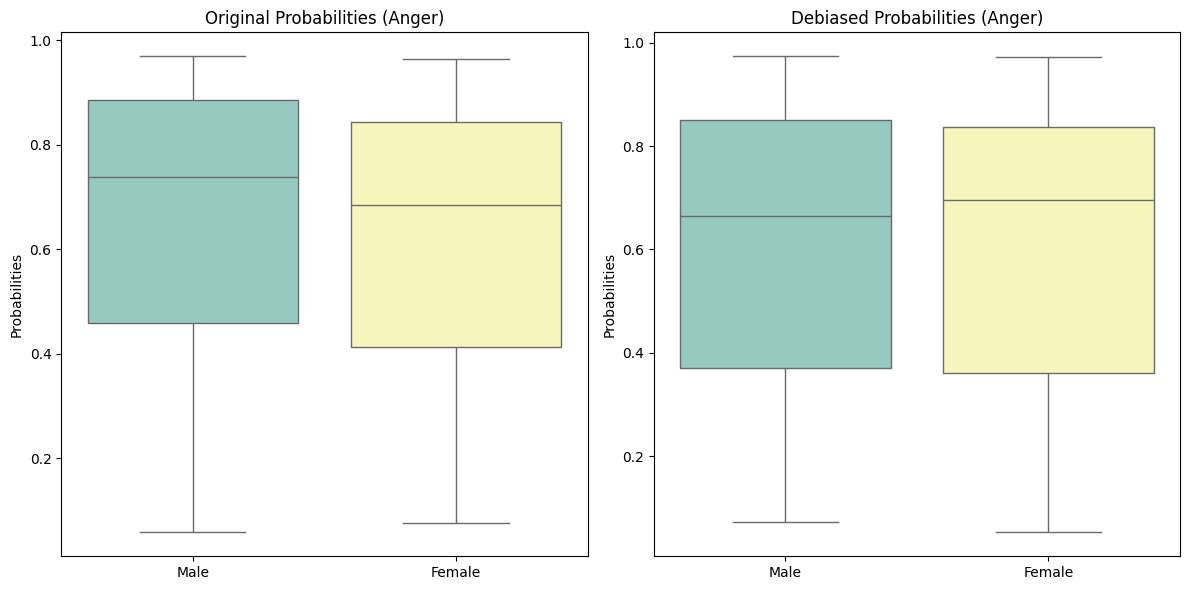

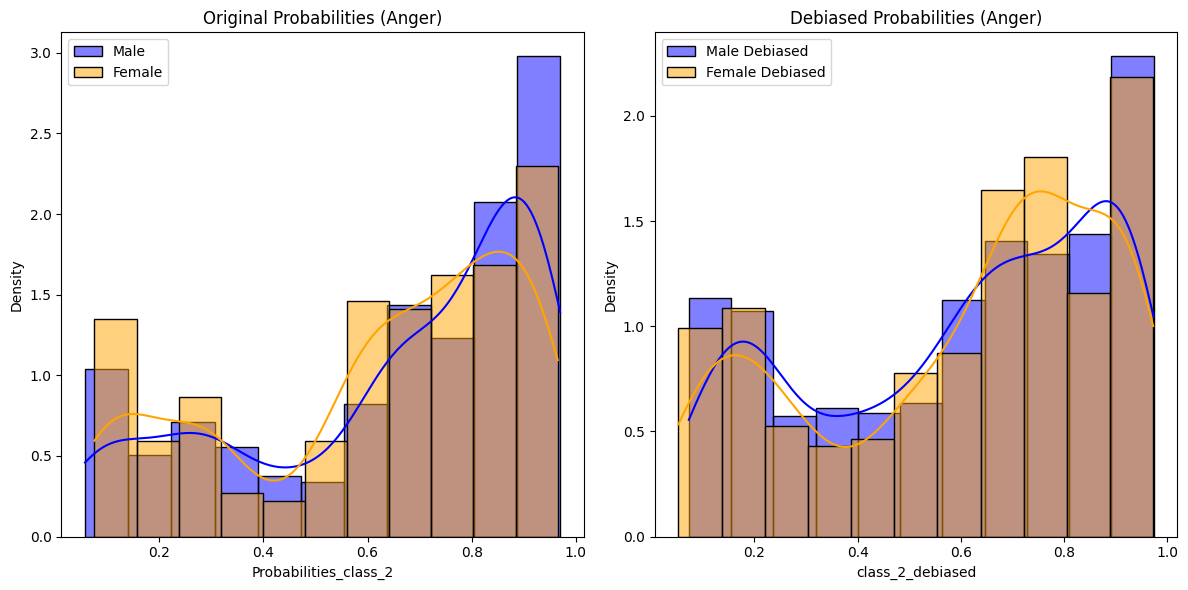

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(12, 6))

# Create two subplots: one for original and one for debiased
plt.subplot(1, 2, 1)
sns.boxplot(data=[sampled_data_anger[male_col], sampled_data_anger[female_col]], palette="Set3")
plt.title("Original Probabilities (Anger)")
plt.xticks([0, 1], ['Male', 'Female'])
plt.ylabel("Probabilities")

plt.subplot(1, 2, 2)
sns.boxplot(data=[sampled_data_anger[male_col_debiased], sampled_data_anger[female_col_debiased]], palette="Set3")
plt.title("Debiased Probabilities (Anger)")
plt.xticks([0, 1], ['Male', 'Female'])
plt.ylabel("Probabilities")

# Display the plot
plt.tight_layout()
plt.show()

# Alternatively, histograms with KDE plots
plt.figure(figsize=(12, 6))

# Create two subplots: one for original and one for debiased
plt.subplot(1, 2, 1)
sns.histplot(sampled_data_anger[male_col], label="Male", kde=True, color="blue", stat="density")
sns.histplot(sampled_data_anger[female_col], label="Female", kde=True, color="orange", stat="density")
plt.title("Original Probabilities (Anger)")
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(sampled_data_anger[male_col_debiased], label="Male Debiased", kde=True, color="blue", stat="density")
sns.histplot(sampled_data_anger[female_col_debiased], label="Female Debiased", kde=True, color="orange", stat="density")
plt.title("Debiased Probabilities (Anger)")
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
